In [1]:
import anndata
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json
import numpy as np
from scipy.stats import fisher_exact

## Parameters

In [2]:
cluster = 'PAL-Inh_Meis2'
annot_names = {
    'CGI':
    'CGI',
    'CGI Shore':
    'CGI_Shore',
    'Promoter':
    'promoter',
    'CGI Promoter':
    'CGI_promoter',
    'Non-CGI Promoter':
    'Non_CGI_promoter',
    'All Genes':
    'gene_all',
    'Exon':
    'exon',
    'First Exon':
    'exon_first',
    'Intron':
    'intron',
    'First Intron':
    'intron_first',
    'Splicing SIte':
    'splicing_site_slop1000',
    'TE DNA': [
        'DNA.DNA', 'DNA.MULE-MuDR', 'DNA.MuDR', 'DNA.PiggyBac', 'DNA.TcMar',
        'DNA.TcMar-Mariner', 'DNA.TcMar-Pogo', 'DNA.TcMar-Tc2',
        'DNA.TcMar-Tigger', 'DNA.hAT', 'DNA.hAT-Blackjack', 'DNA.hAT-Charlie',
        'DNA.hAT-Tip100'
    ],
    'TE LINE': [
        'LINE.CR1', 'LINE.Dong-R4', 'LINE.L1', 'LINE.L2', 'LINE.RTE-BovB',
        'LINE.RTE-X'
    ],
    'TE LTR': [
        'LTR.ERV1', 'LTR.ERVK', 'LTR.ERVL', 'LTR.ERVL-MaLR', 'LTR.Gypsy',
        'LTR.LTR'
    ],
    'TE SINE': [
        'SINE.Alu', 'SINE.B2', 'SINE.B4', 'SINE.Deu', 'SINE.ID', 'SINE.MIR',
        'SINE.tRNA'
    ],
    'Fetal DMR':
    'feDMR',
    'Adult DMR':
    'adultDMR'
}

In [3]:
# Parameters
cluster = "PAL-Inh_Meis1"


### add ATAC peaks

In [4]:

with open(
        '/home/hanliu/project/mouse_rostral_brain/metadata/label_transfer_between_modality/mC-ATAC.SubType.json'
) as f:
    mc_to_atac = json.load(f)
annot_names['ATAC Peaks'] = mc_to_atac[cluster.replace('_', ' ')]

## DMR Matrix

In [5]:
hypo_matrix_path = f'/home/hanliu/project/mouse_rostral_brain/DMR/DMR_Matrix/{cluster}.hypoDMR.index.tsv.gz'
hyper_matrix_path = f'/home/hanliu/project/mouse_rostral_brain/DMR/DMR_Matrix/{cluster}.hyperDMR.index.tsv.gz'

hypo_matrix = pd.read_csv(hypo_matrix_path, index_col=0)
hyper_matrix = pd.read_csv(hyper_matrix_path, index_col=0)

hypo_matrix = hypo_matrix.loc[hypo_matrix.mean(axis=1).sort_values().index]
hyper_matrix = hyper_matrix.loc[hyper_matrix.mean(axis=1).sort_values().index]

In [6]:
hyper_matrix.shape, hypo_matrix.shape

((278626, 200), (106216, 200))

## DMR Annotation

In [7]:
dmr_annotation = anndata.read_h5ad(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusterCardRecipe/DMRAnnotation.genome_features.h5ad'
)
dmr_annotation

AnnData object with n_obs × n_vars = 4722053 × 139 
    var: 'FeatureType'

In [8]:
hypo_anno = dmr_annotation[hypo_matrix.index, :].copy()
hypo_anno.X = hypo_anno.X.tocsc()
hypo_anno

AnnData object with n_obs × n_vars = 106216 × 139 
    var: 'FeatureType'

In [9]:
hyper_anno = dmr_annotation[hyper_matrix.index, :].copy()
hyper_anno.X = hyper_anno.X.tocsc()
hyper_anno

AnnData object with n_obs × n_vars = 278626 × 139 
    var: 'FeatureType'

### use background to calculate null

In [10]:
null_anno = anndata.read_h5ad('/home/hanliu/project/mouse_rostral_brain/DMR/AdultDMRAnnotation/DMRAnnotation.h5ad')

null_anno = null_anno[:, null_anno.var['FeatureType'] != 'MotifHits'].copy()
null_anno.X = null_anno.X.tocsc()
null_anno

AnnData object with n_obs × n_vars = 346920 × 139 
    var: 'FeatureType'

## Assemble data

In [11]:
def get_annot_df(adata):
    records = []
    for k, v in annot_names.items():
        if isinstance(v, list) and len(v) == 1:
            v = v[0]
        if isinstance(v, str):
            data = pd.Series(adata.obs_vector(v), index=adata.obs_names, name=k)
        else:
            data = pd.Series(adata[:, v].X.sum(axis=1).A1 != 0, index=adata.obs_names, name=k).astype(int)
        records.append(data)
    anno_df = pd.DataFrame(records).T
    return anno_df

In [12]:
hypo_anno_df = get_annot_df(hypo_anno)
hyper_anno_df = get_annot_df(hyper_anno)
null_anno_df = get_annot_df(null_anno)

## Plot

In [13]:
matrix_size = 3
labelsize = 6
mc_vmin = 0
mc_vmax = 1

In [14]:
def plot_profile(matrix, anno, enrich_text=None):
    n_annot = len(annot_names)
    fig = plt.figure(figsize=((matrix_size + n_annot) * 0.2, 3), dpi=300)

    gs = fig.add_gridspec(1, matrix_size + n_annot, hspace=0.1, wspace=0.1)

    ax_matrix = fig.add_subplot(gs[0, :matrix_size])

    ax = ax_matrix
    ax.imshow(matrix, aspect='auto', vmin=mc_vmin, vmax=mc_vmax)
    ax.set(xticks=[], yticks=[])
    if enrich_text is not None:
        ax.text(0.5,
                -.04,
                'Fold Change\n(vs Adult DMR)',
                fontsize=labelsize - 2,
                ha='center',
                va='center',
                transform=ax.transAxes)

    for i, (name, col) in enumerate(anno.iteritems()):
        ax = fig.add_subplot(gs[0, i + matrix_size])
        ax.imshow(col.values.reshape(anno.shape[0], 1),
                  aspect='auto',
                  cmap='gray_r',
                  vmin=0,
                  vmax=1)
        ax.text(0.5,
                1.01,
                name,
                fontsize=labelsize,
                rotation=60,
                rotation_mode='anchor',
                transform=ax.transAxes)
        if enrich_text is not None:
            t = enrich_text[name]
            ax.text(0.5,
                    -.01,
                    t,
                    fontsize=labelsize,
                    rotation=90,
                    ha='right',
                    va='center',
                    rotation_mode='anchor',
                    transform=ax.transAxes)
        ax.set(xticks=[], yticks=[])
    return fig


def fisher_test(row):
    a, b, c, d = row
    oddsratio, pvalue = fisher_exact([[a, b], [c, d]])
    return pd.Series({'Odds': oddsratio, 'P-value': pvalue})

In [15]:
null_hit = (null_anno_df == 1).sum(axis=0)
null_empty = (null_anno_df == 0).sum(axis=0)
hypo_hit = (hypo_anno_df == 1).sum(axis=0)
hypo_empty = (hypo_anno_df == 0).sum(axis=0)

tables = pd.DataFrame([hypo_hit, hypo_empty, null_hit, null_empty]).T
enrichment = tables.apply(fisher_test, axis=1)
enrich_text = enrichment.apply(lambda i: f"{'*' if i['P-value'] < 1e-3 else ''}{i['Odds']:.1f}", axis=1)

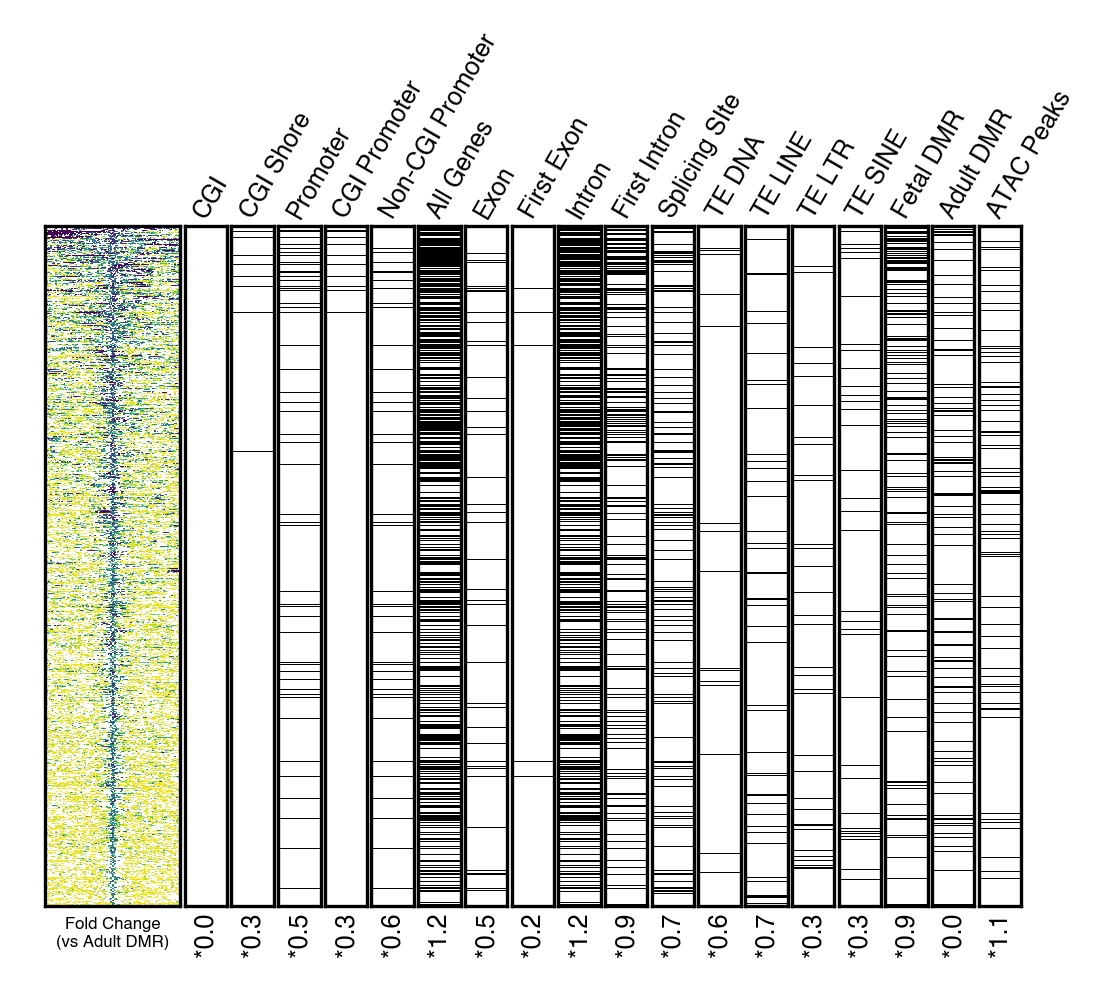

In [16]:
hypo_fig = plot_profile(hypo_matrix, hypo_anno_df, enrich_text)

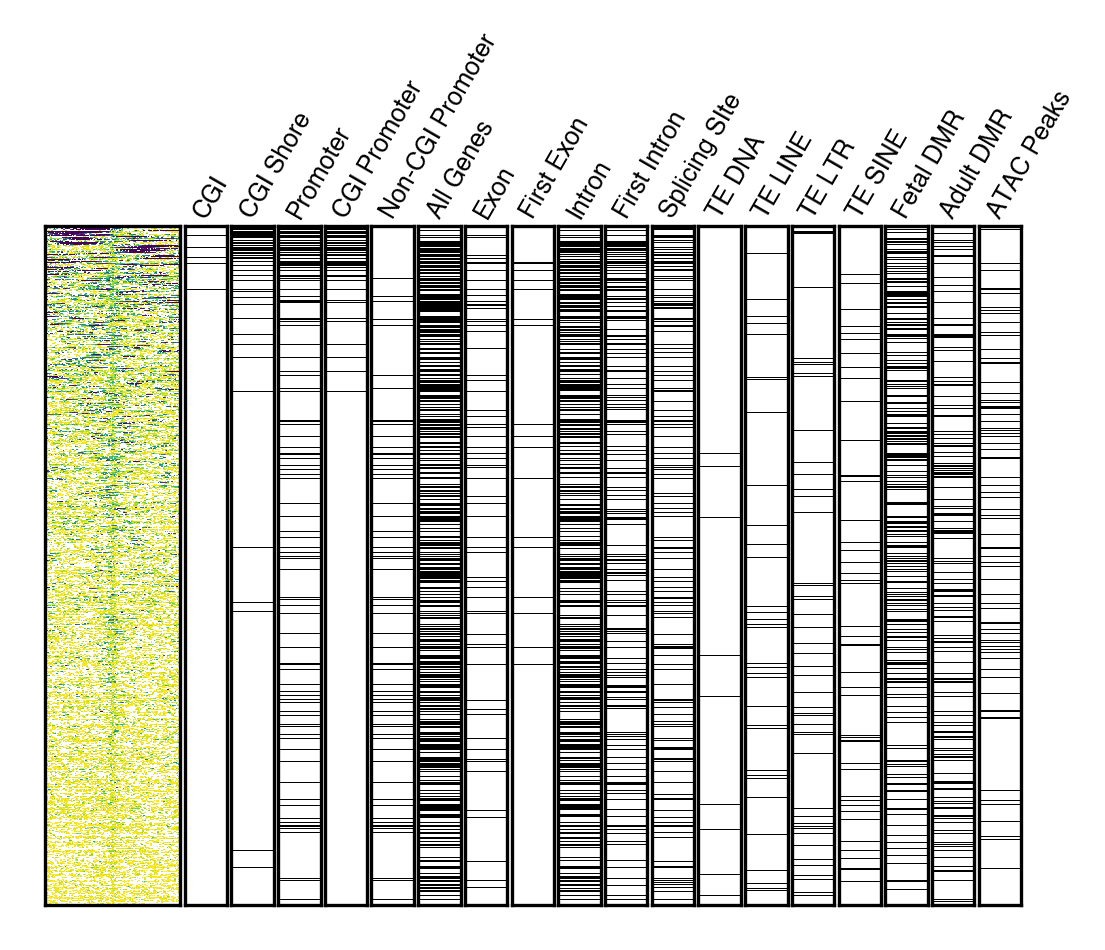

In [17]:
hyper_fig = plot_profile(hyper_matrix, hyper_anno_df)